<a href="https://colab.research.google.com/github/NicKostii/UniProjects/blob/main/danbooru_multilabel_classification/Danbooru_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-multilearn
!pip install iterative-stratification

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 4.8 MB/s eta 0:00:00


In [ ]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import random

import tensorflow as tf
from tensorflow.keras import layers, models, applications, initializers, metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, AUC
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint


from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle
from skmultilearn.model_selection import IterativeStratification
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [ ]:
images_zip_path = '/content/drive/MyDrive/Datasets/Danbooru/downscaled_images.zip'
metadata_path = '/content/drive/MyDrive/Datasets/Danbooru/filtered_metadata.jsonl'
extract_to = '/content/dataset_images'
images_path = '/content/dataset_images/downscaled_images'

In [ ]:
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

with zipfile.ZipFile(images_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


metadata = []
with open(metadata_path, 'r') as f:
    for line in f:
        metadata.append(json.loads(line))

df = pd.DataFrame(metadata)


image_files = os.listdir(images_path)
image_ids = [os.path.splitext(f)[0] for f in image_files]
df = df[df['id'].astype(str).isin(image_ids)]
df['image_path'] = df['id'].apply(lambda x: os.path.join(images_path, f"{x}.jpg"))


mlb = MultiLabelBinarizer()
tags_encoded = mlb.fit_transform(df['tags'])


mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = df['image_path'].values
y = tags_encoded

for train_idx, test_idx in mskf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    break


def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 255.0  # Нормалізація [0, 1]
    return image

def create_dataset(image_paths, labels, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(X_train, y_train, batch_size=32, shuffle=True)
test_dataset = create_dataset(X_test, y_test, batch_size=32, shuffle=False)

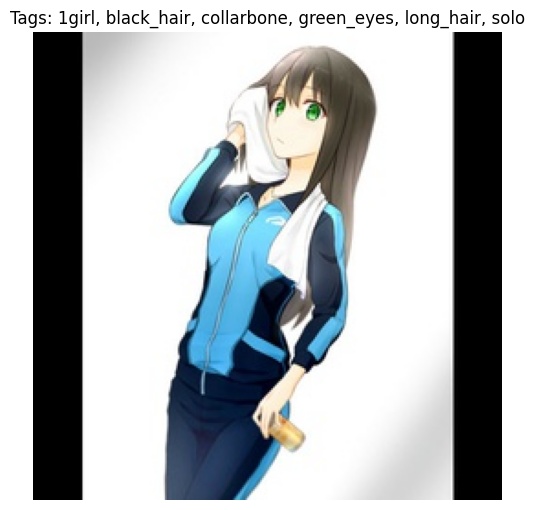

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(1):
    idx = np.random.randint(0, len(X_train))
    img_path = X_train[idx]
    tags = y_train[idx]

    # Отримуємо текстові теги з бінарного вектора
    active_tags = np.array(mlb.classes_)[tags.astype(bool)]

    img = plt.imread(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"Tags: {', '.join(active_tags)}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from keras.saving import register_keras_serializable

In [ ]:
@register_keras_serializable()
class SEBlock(layers.Layer):
    def __init__(self, ratio=0.25, **kwargs):
        super(SEBlock, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.squeeze_units = max(1, int(self.channels * self.ratio))

        self.squeeze = layers.Dense(self.squeeze_units, activation='relu')
        self.excite = layers.Dense(self.channels, activation='sigmoid')

    def call(self, inputs):
        x = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        x = self.squeeze(x)
        x = self.excite(x)
        return inputs * x

    def get_config(self):
        config = super().get_config()
        config.update({
            "ratio": self.ratio
        })
        return config

In [ ]:
@register_keras_serializable()
def resnet_block(x, filters, kernel_size=3, stride=1, use_se=False):
    shortcut = x

    # Conv1
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Conv2
    x = layers.Conv2D(filters, kernel_size, padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    # Shortcut connection
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride,
                                kernel_initializer='he_normal')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # SE Block
    if use_se:
        x = SEBlock()(x)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

In [ ]:
@register_keras_serializable()
def unified_focal_loss(y_true, y_pred, alpha=0.5, gamma=2.0):

    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)

    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    focal_weight = tf.pow(1.0 - p_t, gamma)

    loss = alpha * focal_weight * bce
    return tf.reduce_mean(loss)

In [ ]:
def build_model(input_shape=(256, 256, 3), num_classes=100, use_se=True):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same',
                      kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # ResNet блоки
    filters = [64, 128, 256, 512]
    strides = [1, 2, 2, 2]

    for i, (f, s) in enumerate(zip(filters, strides)):
        for j in range(2 if i < 2 else 3):  # Більше блоків у глибоких шарах
            x = resnet_block(x, f, stride=s if j == 0 else 1, use_se=use_se)

    # Фінальні шари
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

model = build_model(input_shape=(256, 256, 3), num_classes=100, use_se=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=unified_focal_loss,
    metrics=[
        'binary_accuracy',
        metrics.F1Score(average='macro', name='f1_macro'),
        metrics.F1Score(average='micro', name='f1_micro')
    ]
)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 128, 128,  │      9,472 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_42 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ re_lu_42[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 64, 64,    │     36,928 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_43 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 64, 64,    │     36,928 │ re_lu_43[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ se_block_20         │ (None, 64, 64,    │      2,128 │ batch_normalizat… │
│ (SEBlock)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 64, 64,    │          0 │ se_block_20[0][0… │
│                     │ 64)               │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_44 (ReLU)     │ (None, 64, 64,    │          0 │ add_20[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 64, 64,    │     36,928 │ re_lu_44[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_51[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_45 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 64, 64,    │     36,928 │ re_lu_45[0][0]  

 Total params: 17,663,492 (67.38 MB)

 Trainable params: 17,650,820 (67.33 MB)

 Non-trainable params: 12,672 (49.50 KB)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/models/best_model.keras',
        save_best_only=True,
        monitor='val_f1_macro',
        mode='max',
        verbose=1,
        save_weights_only=False
    ),


    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_f1_macro',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        mode='max',
        verbose=1
    ),

    tf.keras.callbacks.EarlyStopping(
        monitor='val_f1_macro',
        patience=5,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),

    tf.keras.callbacks.TensorBoard(
        log_dir='/content/drive/MyDrive/models/logs',
        histogram_freq=0,
        update_freq='epoch'
    )
]

In [ ]:
epochs_per_stage = 10
total_stages = 5

# Навчання по етапах
for stage in range(total_stages):
    print(f"\n=== Stage {stage + 1}/{total_stages} ===")

    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=(stage + 1) * epochs_per_stage,
        initial_epoch=stage * epochs_per_stage,
        callbacks=callbacks,
        verbose=1
    )

    if stage == 0:
        # Зменшення LR після першого етапу
        model.optimizer.learning_rate.assign(0.00001)
        if hasattr(model, 'unfreeze_layers'):
            model.unfreeze_layers(0.3)


=== Stage 1/3 ===
Epoch 1/5
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - binary_accuracy: 0.8999 - f1_macro: 0.0245 - f1_micro: 0.1175 - loss: 0.0405
Epoch 1: val_f1_macro improved from -inf to 0.02124, saving model to /content/drive/MyDrive/models/best_model.keras
610/610 ━━━━━━━━━━━━━━━━━━━━ 109s 179ms/step - binary_accuracy: 0.8999 - f1_macro: 0.0245 - f1_micro: 0.1175 - loss: 0.0405 - val_binary_accuracy: 0.9006 - val_f1_macro: 0.0212 - val_f1_micro: 0.1215 - val_loss: 0.0392 - learning_rate: 1.0000e-04
Epoch 2/5
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - binary_accuracy: 0.9014 - f1_macro: 0.0254 - f1_micro: 0.1220 - loss: 0.0396
Epoch 2: val_f1_macro improved from 0.02124 to 0.02333, saving model to /content/drive/MyDrive/models/best_model.keras
610/610 ━━━━━━━━━━━━━━━━━━━━ 142s 179ms/step - binary_accuracy: 0.9014 - f1_macro: 0.0254 - f1_micro: 0.1220 - loss: 0.0396 - val_binary_accuracy: 0.8993 - val_f1_macro: 0.0233 - val_f1_micro: 0.1159 - val_loss: 0.0396 - learning_rate:

AttributeError: 'Adam' object has no attribute 'lr'

In [ ]:
epochs_per_stage = 10
total_stages = 5


for stage in range(total_stages):
    print(f"\n=== Stage {stage + 1}/{total_stages} ===")

    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=(stage + 1) * epochs_per_stage,
        initial_epoch=stage * epochs_per_stage,
        callbacks=callbacks,
        verbose=1
    )

    if stage == 0:

        model.optimizer.learning_rate.assign(0.00001)

        if hasattr(model, 'unfreeze_layers'):
            model.unfreeze_layers(0.3)


=== Stage 1/5 ===
Epoch 1/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - binary_accuracy: 0.9047 - f1_macro: 0.0326 - f1_micro: 0.1314 - loss: 0.0369
Epoch 1: val_f1_macro improved from -inf to 0.03101, saving model to /content/drive/MyDrive/models/best_model.keras
610/610 ━━━━━━━━━━━━━━━━━━━━ 113s 185ms/step - binary_accuracy: 0.9047 - f1_macro: 0.0326 - f1_micro: 0.1314 - loss: 0.0369 - val_binary_accuracy: 0.9031 - val_f1_macro: 0.0310 - val_f1_micro: 0.1295 - val_loss: 0.0390 - learning_rate: 5.0000e-05
Epoch 2/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - binary_accuracy: 0.9061 - f1_macro: 0.0339 - f1_micro: 0.1350 - loss: 0.0363
Epoch 2: val_f1_macro did not improve from 0.03101
610/610 ━━━━━━━━━━━━━━━━━━━━ 136s 176ms/step - binary_accuracy: 0.9061 - f1_macro: 0.0339 - f1_micro: 0.1350 - loss: 0.0363 - val_binary_accuracy: 0.9040 - val_f1_macro: 0.0304 - val_f1_micro: 0.1283 - val_loss: 0.0371 - learning_rate: 5.0000e-05
Epoch 3/10
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step 

In [ ]:
from sklearn.metrics import f1_score


y_pred = model.predict(test_dataset)
y_pred_binary = (y_pred > 0.5).astype(int)


f1_macro = f1_score(y_test, y_pred_binary, average='macro')
f1_micro = f1_score(y_test, y_pred_binary, average='micro')

print(f"F1-score (Macro): {f1_macro:.4f}")
print(f"F1-score (Micro): {f1_micro:.4f}")

153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step
F1-score (Macro): 0.1225
F1-score (Micro): 0.3097


In [ ]:
top_tags_indices = np.argsort(np.sum(y_test, axis=0))[-10:][::-1]
top_tags = mlb.classes_[top_tags_indices]

print("\nPerformance on top tags:")
for tag, idx in zip(top_tags, top_tags_indices):
    tag_f1 = f1_score(y_test[:, idx], y_pred_binary[:, idx])
    print(f"{tag}: F1 = {tag_f1:.4f}")


Performance on top tags:
1girl: F1 = 0.8012
solo: F1 = 0.7598
long_hair: F1 = 0.5095
smile: F1 = 0.2321
short_hair: F1 = 0.1374
multiple_girls: F1 = 0.5187
blush: F1 = 0.2180
open_mouth: F1 = 0.1449
looking_at_viewer: F1 = 0.2067
blonde_hair: F1 = 0.5288


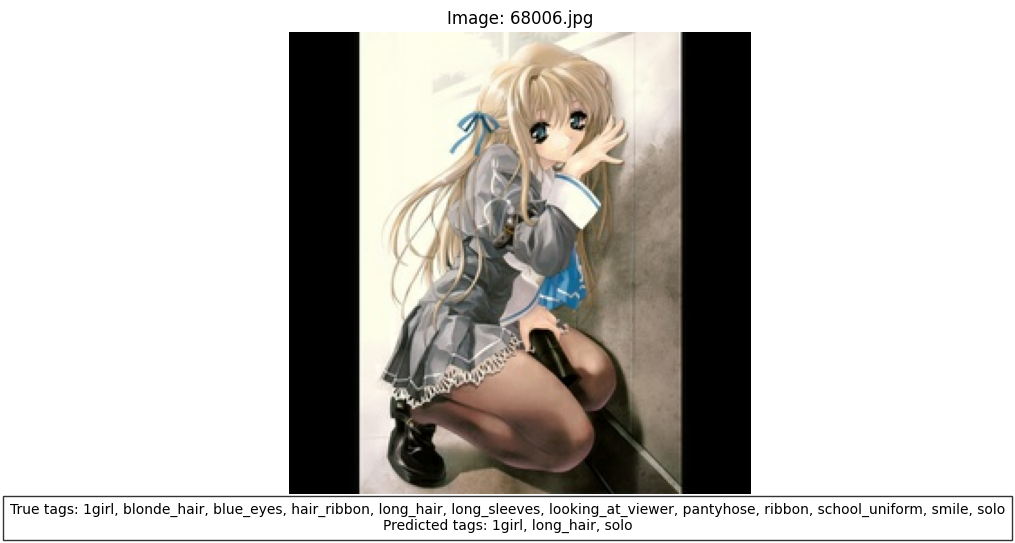

In [ ]:
# Вибір випадкового індексу з тестового набору
random_idx = random.randint(0, len(X_test) - 1)
image_path = X_test[random_idx]
true_tags = y_test[random_idx]
pred_tags = y_pred_binary[random_idx]

# Завантаження та підготовка зображення
image = load_and_preprocess_image(image_path)
image = image.numpy()

# Отримання назв тегів
# Перетворюємо 1D масив у 2D (1 sample, N tags) для inverse_transform
true_tag_names = mlb.inverse_transform(np.array([true_tags]))[0]
pred_tag_names = mlb.inverse_transform(np.array([pred_tags]))[0]

plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.title(f"Image: {os.path.basename(image_path)}", fontsize=12)
plt.axis('off')
tag_text = "True tags: " + ", ".join(true_tag_names) + "\n" + "Predicted tags: " + ", ".join(pred_tag_names)
plt.figtext(0.5, 0.05, tag_text, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.8, "pad":5})

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Datasets/Danbooru dataset/Models/my_model_2.keras')

In [ ]:
custom_objects = {
    "SEBlock": SEBlock,
    "unified_focal_loss": unified_focal_loss,
}

model = tf.keras.models.load_model(
    '/content/drive/MyDrive/Datasets/Danbooru/Models/my_model_2.keras',
    custom_objects=custom_objects
)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 140 variables whereas the saved optimizer has 278 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
from sklearn.metrics import f1_score

# Прогнозуємо на тестовому наборі
y_pred = model.predict(test_dataset)

153/153 ━━━━━━━━━━━━━━━━━━━━ 861s 6s/step


In [ ]:
y_pred_binary = (y_pred > 0.43).astype(int)  # Бінаризуємо прогнози

# Обчислюємо F1-score (macro та micro)
f1_macro = f1_score(y_test, y_pred_binary, average='macro')
f1_micro = f1_score(y_test, y_pred_binary, average='micro')

print(f"F1-score (Macro): {f1_macro:.4f}")
print(f"F1-score (Micro): {f1_micro:.4f}")

F1-score (Macro): 0.1865
F1-score (Micro): 0.3778


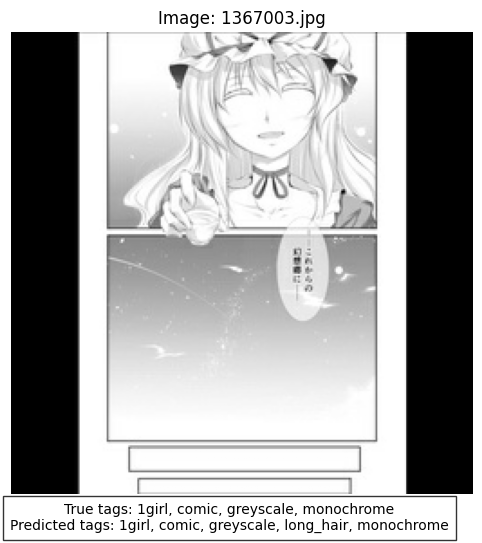

In [ ]:
# Вибір випадкового індексу з тестового набору
random_idx = random.randint(0, len(X_test) - 1)
image_path = X_test[random_idx]
true_tags = y_test[random_idx]  # Це numpy масив (з бінарними мітками)
pred_tags = y_pred_binary[random_idx]  # Це numpy масив (з бінарними мітками)

# Завантаження та підготовка зображення
image = load_and_preprocess_image(image_path)
image = image.numpy()

# Отримання назв тегів
# Перетворюємо 1D масив у 2D (1 sample, N tags) для inverse_transform
true_tag_names = mlb.inverse_transform(np.array([true_tags]))[0]
pred_tag_names = mlb.inverse_transform(np.array([pred_tags]))[0]

plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.title(f"Image: {os.path.basename(image_path)}", fontsize=12)
plt.axis('off')

tag_text = "True tags: " + ", ".join(true_tag_names) + "\n" + "Predicted tags: " + ", ".join(pred_tag_names)
plt.figtext(0.5, 0.05, tag_text, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.8, "pad":5})

plt.show()